## Модуль Б.  Разведочный анализ данных

#### Импортирование библиотек

In [1]:
import pandas as pd
import io
import glob
import re
import nltk
import matplotlib.pyplot as plt
import pymorphy2
import fitz
import string
import numpy as np
import re
import pyLDAvis
import pyLDAvis.gensim
from nltk.stem import *
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm, trange
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn
from __future__ import division
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

### 1.2 Формирование структуры набора данных

### Описание структуры данных

__TitleCompany__ - Название компании

__Description__ - Описание компании

__Reiting__ - Рейтинг компании

__Categories__ - Категории компании


__TitleCompany__ - Название компании

__Description__ - Описание компании

__Reiting__ - Рейтинг компании

__Categories__ - Категории компании

__TextPostLemat__ - обработанный, лематизированный текст 

__TextPostToken__ - обработанный, токенизированный и лематизированный текст (лематизирован другим способом нежели TextPostLemat)

__bigram__ - биграммы обработанного и лематизированного текста

__trigram__ - триграммы обработанного и лематизированного текста

__keyword__ - ключевые слова обработанного и лематизированного текста

__clustersAgglomerative__ - кластеры, образованные моделью Agglomerative

__clustersKmeans__ - кластеры, образованные моделью Kmeans

__clustersSpectral__ - кластеры, образованные моделью Spectral

#### Установка библиотек

### 2.1 Поиск ключевых слов/n-грамм. Векторизация текстов

In [2]:
dfHabr1 = pd.read_csv('Report1.csv')

In [3]:
mystem = Mystem() 
# добавление стопслов
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['…', '«', '»', '...', 'быть', 'r', 'n', 'а', 'мы', 'с', 'для', 'ещё', 'его', 'также', 'к', 'тем', 'кто', 'чтобы', 'но', 'они', 'будут', 'так', 'где', 'один', 'он ', 'и', 'на', 'но', 'или', 'либо', 'это', 'мб', 'далее', 'дв', 'свой', 'ваш','всё', 'очень', 'её', 'ещё', 'вообще', 'наш', 'который'])

Из-за проблем с чтением нужно заново токенизировать текст, именно поэтому заново прописываю метод токенизации на лемматизированном тексте

In [4]:
def tokenize(text):
    t = word_tokenize(text)
    return [token for token in t if token not in russian_stopwords]

In [5]:
prep_text1 = [tokenize(text.lower()) for text in tqdm(dfHabr1['TextPostLemat']) if text not in russian_stopwords]

  0%|          | 0/87 [00:00<?, ?it/s]

In [6]:
dfHabr1['TextPostToken'] = prep_text1

In [7]:
dfHabr1['bigram'] = ''
dfHabr1['trigram'] = ''
dfHabr1['keyword'] = ''

In [8]:
# использование цикла с записью биграмм в датафрейм
for i in tqdm(range(len(dfHabr1['TextPostToken']))):
    dfHabr1['bigram'][i] = list(nltk.ngrams(dfHabr1['TextPostToken'][i], 2))
# использование цикла с записью триграмм в датафрейм
for i in tqdm(range(len(dfHabr1['TextPostToken']))):
    dfHabr1['trigram'][i] = list(nltk.ngrams(dfHabr1['TextPostToken'][i], 3))
# использование цикла с записью ключевых слов в датафрейм
for i in tqdm(range(len(dfHabr1['TextPostToken']))):
    freq_dist = nltk.FreqDist(dfHabr1['TextPostToken'][i])
    top_words = [word for word, count in freq_dist.most_common(10)]
    dfHabr1['keyword'][i] = ', '.join(top_words)

  0%|          | 0/87 [00:00<?, ?it/s]

C:\Users\essww\AppData\Local\Temp\ipykernel_14508\4148636806.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfHabr1['bigram'][i] = list(nltk.ngrams(dfHabr1['TextPostToken'][i], 2))


  0%|          | 0/87 [00:00<?, ?it/s]

C:\Users\essww\AppData\Local\Temp\ipykernel_14508\4148636806.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfHabr1['trigram'][i] = list(nltk.ngrams(dfHabr1['TextPostToken'][i], 3))


  0%|          | 0/87 [00:00<?, ?it/s]

C:\Users\essww\AppData\Local\Temp\ipykernel_14508\4148636806.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfHabr1['keyword'][i] = ', '.join(top_words)


In [9]:
dfHabr1.head()

,TitleCompany,Description,Reiting,Categories,TextPostLemat,TextPostToken,bigram,trigram,keyword
0,RUVDS.com,VDS/VPS-хостинг. Скидка 15% по коду HABR15,2393.91,"Электроника для начинающих, Системное админист...",языковой модель заменять программист непосредс...,"[языковой, модель, заменять, программист, непо...","[(языковой, модель), (модель, заменять), (заме...","[(языковой, модель, заменять), (модель, заменя...","код, модель, плагин, поиск, данные, разработка..."
1,FirstVDS,Виртуальные и выделенные серверы в ДЦ в Москве,398.02,"Читальный зал, Информационная безопасность, IT...",приветствовать читатель время идти весь новый ...,"[приветствовать, читатель, время, идти, весь, ...","[(приветствовать, читатель), (читатель, время)...","[(приветствовать, читатель, время), (читатель,...","файл, уязвимость, процесс, весь, код, использо..."
2,Timeweb Cloud,Облачная платформа для разработчиков и бизнеса,1542.55,"DIY или Сделай сам, История IT",интересный занятие изучать история техника оты...,"[интересный, занятие, изучать, история, техник...","[(интересный, занятие), (занятие, изучать), (и...","[(интересный, занятие, изучать), (занятие, изу...","плата, процессор, сервер, слот, контроллер, си..."
3,Southbridge,Обеспечиваем стабильную работу highload-проектов,272.35,"Карьера в IT-индустрии, Программирование",платформа оркестрация контейнер однако настрой...,"[платформа, оркестрация, контейнер, однако, на...","[(платформа, оркестрация), (оркестрация, конте...","[(платформа, оркестрация, контейнер), (оркестр...","кластер, узел, команда, мочь, машина, установк..."
4,Яндекс,Как мы делаем Яндекс,721.53,"Высокая производительность, Программирование, ...",привет звать артур яковлев делать голосовой пе...,"[привет, звать, артур, яковлев, делать, голосо...","[(привет, звать), (звать, артур), (артур, яков...","[(привет, звать, артур), (звать, артур, яковле...","китайский, модель, перевод, язык, видео, тон, ..."


In [10]:
def preprocess_text(data, stopwords=russian_stopwords):
    text = re.sub('ё','е', data.lower())
    text = text.strip()
    text = [w for w in text.split() if w not in stopwords] 
    text = [w for w in text if len(w) >=3]
    return ' '.join(text)

In [11]:
def transform_data(data: pd.Series) -> list:
    result = [preprocess_text(data=i) for i in data]
    return result

In [12]:
text = dfHabr1['TextPostLemat']

In [13]:
%%time
dfHabr2 = transform_data(text)

CPU times: total: 156 ms
Wall time: 175 ms


In [14]:
len(dfHabr2)

87

In [15]:
vectorizer = CountVectorizer(analyzer='word', stop_words=russian_stopwords, ngram_range=(1, 3), min_df=1)
count_matrix = vectorizer.fit_transform(dfHabr2)

In [16]:
count_matrix.toarray()[:2,:200]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 

In [17]:
count_matrix.shape

(87, 157648)

In [18]:
vectorizer.get_feature_names_out()[:50]

array(['ааа', 'ааа класс', 'ааа класс требовать', 'ааа проект',
       'ааа проект современность', 'аббревиатура',
       'аббревиатура название', 'аббревиатура название большинство',
       'аббревиатура обозначать', 'аббревиатура обозначать сторона',
       'аббревиатура расшифровываться',
       'аббревиатура расшифровываться запрос', 'абитуриент',
       'абитуриент вопрос', 'абитуриент вопрос прежде', 'абразив',
       'абразив кварц', 'абразив кварц угольный', 'абрам',
       'абрам совместный', 'абрам совместный работа', 'абрам старший',
       'абрам старший директор', 'абсолютно', 'абсолютно важно',
       'абсолютно важно игра', 'абсолютно любой',
       'абсолютно любой локация', 'абсолютно непонятный',
       'абсолютно непонятный вещь', 'абсолютно никуда',
       'абсолютно никуда полететь', 'абсолютно новый',
       'абсолютно новый технология', 'абсолютно нормальный',
       'абсолютно нормальный браузерный', 'абсолютно разный',
       'абсолютно разный неявный', 'абсолю

In [19]:
len(vectorizer.get_feature_names_out())

157648

### 2.3 Кластеризация

In [20]:
# Выбор и применение алгоритма кластеризации
agg = AgglomerativeClustering(n_clusters=11).fit(count_matrix.toarray())

In [21]:
# Получение меток кластеров
labelsAgglomerative = agg.labels_
clusters1 = agg.labels_.tolist()

In [22]:
agg.labels_

array([ 1,  0,  0,  1,  1,  1,  1,  1,  5,  1,  1,  1,  0,  6,  1,  1,  1,
        1,  1,  1, 10,  0,  1,  1,  1,  0,  1,  1,  0,  9,  7,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  8,  1,  1,  1,  1,  2,  1,  1,  0,  1,  1,
        0,  0,  1,  0,  1,  0,  1,  1,  0,  0,  1,  2,  0,  1,  1,  1,  1,
        3,  1,  1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  4,  1,
        2,  1], dtype=int64)

In [23]:
dfHabr1['clustersAgglomerative'] = clusters1

In [24]:
# Метод к-средних - KMeans
km = KMeans(n_clusters=11).fit(count_matrix.toarray())

C:\Users\essww\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\essww\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [25]:
labelsKmeans = km.labels_
clusters2 = km.labels_.tolist()

In [26]:
dfHabr1['clustersKmeans'] = clusters2

In [27]:
# Создание модели DBSCAN
spectral = SpectralClustering(n_clusters=11).fit(count_matrix.toarray())

C:\Users\essww\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\essww\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [28]:
labelsSpectral = spectral.labels_
clusters3 = spectral.labels_.tolist()

In [29]:
dfHabr1['clustersSpectral'] = clusters3

In [30]:
print(labelsSpectral)

[ 1  1  1  0  3  1  1  1  2  1  1  1  8  7 10  8  1  0  8  1  3  1  1  1
  3 10  1  1  0  1  2  0  1  8  1  3  1  1  1  8  2  3  2  8  1  8  1  1
  0  8 10  7  1  9  8  8  5  3  3  3  0  8  1  1  1  1  2  1  1  8  4  8
 10  1  3  1  0  1  3  3  3  3  2  3  6  0  8]


In [31]:
print(labelsKmeans)

[ 4  2  4  2  4  4  4  4  7  4  4  4  2  9  4  4  4  4  4  4  4 10  4  4
  4  4  2  4  4  6  8  4  4  4  4  4  4  4  4  4  3  4  4  4  4  4  4  4
  4  4  4  4  4  2  4  4  4  4  4  2  4  4  0  4  4  4  4  4  1  4  4  4
  4  4  4  2  4  4  4  4  4  4  4  5  4  4  4]


In [32]:
print(labelsAgglomerative)

[ 1  0  0  1  1  1  1  1  5  1  1  1  0  6  1  1  1  1  1  1 10  0  1  1
  1  0  1  1  0  9  7  0  0  1  1  1  1  1  1  1  8  1  1  1  1  2  1  1
  0  1  1  0  0  1  0  1  0  1  1  0  0  1  2  0  1  1  1  1  3  1  1  0
  0  1  1  1  1  1  1  1  1  1  0  4  1  2  1]


In [33]:
dfHabr1.head()

,TitleCompany,Description,Reiting,Categories,TextPostLemat,TextPostToken,bigram,trigram,keyword,clustersAgglomerative,clustersKmeans,clustersSpectral
0,RUVDS.com,VDS/VPS-хостинг. Скидка 15% по коду HABR15,2393.91,"Электроника для начинающих, Системное админист...",языковой модель заменять программист непосредс...,"[языковой, модель, заменять, программист, непо...","[(языковой, модель), (модель, заменять), (заме...","[(языковой, модель, заменять), (модель, заменя...","код, модель, плагин, поиск, данные, разработка...",1,4,1
1,FirstVDS,Виртуальные и выделенные серверы в ДЦ в Москве,398.02,"Читальный зал, Информационная безопасность, IT...",приветствовать читатель время идти весь новый ...,"[приветствовать, читатель, время, идти, весь, ...","[(приветствовать, читатель), (читатель, время)...","[(приветствовать, читатель, время), (читатель,...","файл, уязвимость, процесс, весь, код, использо...",0,2,1
2,Timeweb Cloud,Облачная платформа для разработчиков и бизнеса,1542.55,"DIY или Сделай сам, История IT",интересный занятие изучать история техника оты...,"[интересный, занятие, изучать, история, техник...","[(интересный, занятие), (занятие, изучать), (и...","[(интересный, занятие, изучать), (занятие, изу...","плата, процессор, сервер, слот, контроллер, си...",0,4,1
3,Southbridge,Обеспечиваем стабильную работу highload-проектов,272.35,"Карьера в IT-индустрии, Программирование",платформа оркестрация контейнер однако настрой...,"[платформа, оркестрация, контейнер, однако, на...","[(платформа, оркестрация), (оркестрация, конте...","[(платформа, оркестрация, контейнер), (оркестр...","кластер, узел, команда, мочь, машина, установк...",1,2,0
4,Яндекс,Как мы делаем Яндекс,721.53,"Высокая производительность, Программирование, ...",привет звать артур яковлев делать голосовой пе...,"[привет, звать, артур, яковлев, делать, голосо...","[(привет, звать), (звать, артур), (артур, яков...","[(привет, звать, артур), (звать, артур, яковле...","китайский, модель, перевод, язык, видео, тон, ...",1,4,3


In [34]:
topic = ['RUVDS.com', 'Selectel', 'Timeweb Cloud', 'OTUS', 'Яндекс', 'Open Data Science', 'ГК ЛАНИТ', 'VK', 'getmatch', 'Wiren Board', 'FirstVDS', 'Конференции Олега Бунина (Онтико)', 'AGIMA', 'Альфа-Банк', 'Postgres Professional', 'Ozon Tech', 'TINKOFF', 'Хабр Карьера', 'JUG Ru Group', 'Southbridge']

In [ ]:
clust_res = pd.DataFrame(columns=['topic', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10'])
i = 0
for topic in topics:
    cnt = []
    for cluster in range(num_clusters):
        cnt.append(len(frame1[ frame1.topic.eq(topic) &  frame1.cluster.eq(cluster) ]))
    clust_res.loc[i] = [topic] + cnt
    i += 1
clust_res

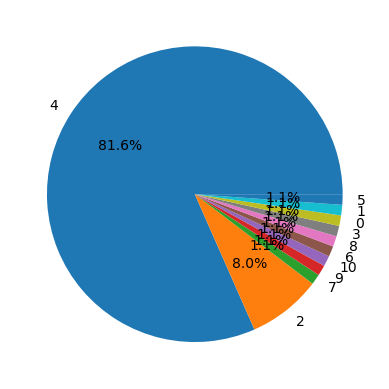

In [36]:
cluster_counts = dfHabr1['clustersKmeans'].value_counts()
plt.pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%')
plt.show()

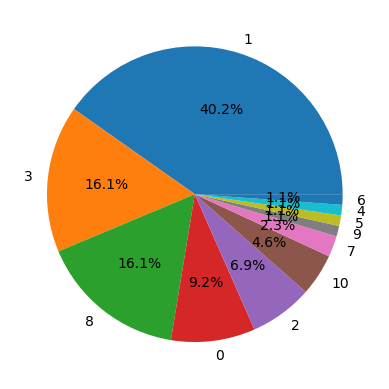

In [37]:
cluster_counts = dfHabr1['clustersSpectral'].value_counts()
plt.pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%')
plt.show()

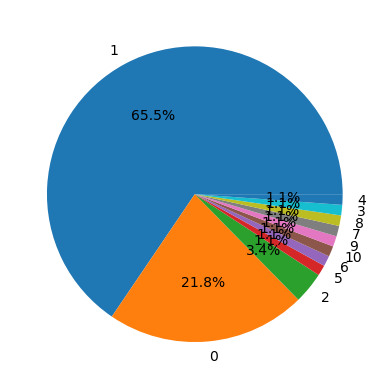

In [38]:
cluster_counts = dfHabr1['clustersAgglomerative'].value_counts()
plt.pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%')
plt.show()

In [39]:
prize = ['Государство и Общество','СМИ и массовые коммуникации','Образование и Кадры', 'Экономика и Бизнес', 'Путешествия по РФ', 'Наука, технологии и инновации', 'Здоровье и Отдых', 'Культурные проекты в сети', 'Народов много - Родина одна', 'Туризм и индустрия гостеприимства', 'Подкасты и цифровой контент']

In [40]:
a = (dfHabr1['clustersKmeans'] - dfHabr1['clustersKmeans'].mean()) / dfHabr1['clustersKmeans'].std()
a1 = (dfHabr1['clustersAgglomerative'] - dfHabr1['clustersAgglomerative'].mean()) / dfHabr1['clustersAgglomerative'].std()
a2 = (dfHabr1['clustersSpectral'] - dfHabr1['clustersSpectral'].mean()) / dfHabr1['clustersSpectral'].std()

In [41]:
data_norm_kmeans = a.values.reshape(-1, 1)
data_norm_agg = a1.values.reshape(-1, 1)
data_norm_spec = a2.values.reshape(-1, 1)

In [42]:
# оценка качества кластеризации с помощью индекса силуэта
silhouette_avg = silhouette_score(data_norm_kmeans, km.labels_)
print("Silhouette  score:", silhouette_avg)

Silhouette  score: 0.896551724137931


In [43]:
# оценка качества кластеризации с помощью индекса силуэта
silhouette_avg = silhouette_score(data_norm_agg, agg.labels_)
print("Silhouette  score:", silhouette_avg)

Silhouette  score: 0.9080459770114943


In [44]:
# оценка качества кластеризации с помощью индекса силуэта
silhouette_avg = silhouette_score(data_norm_spec, spectral.labels_)
print("Silhouette  score:", silhouette_avg)

Silhouette  score: 0.9540229885057471


### 2.2 Тематическое моделирование

In [45]:
# создание модели LDA
lda_model = LatentDirichletAllocation(n_components=11, random_state=0)
lda_model.fit(count_matrix)

# вывод топ слов для каждой темы
for i, topic in enumerate(lda_model.components_):
    print(f"Topic {i}: {', '.join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: данные, мочь, весь, использовать, файл, функция, работать, новый, сигнал, значение
Topic 1: мочь, дыра, игра, ошибка, команда, сервер, весь, создавать, чрной, чрной дыра
Topic 2: класс, объект, десериализация, поле, значение, библиотека, сериализатор, результат, сериализация, использование
Topic 3: работа, мочь, данные, анимация, использовать, год, весь, запрос, самый, время
Topic 4: реактивный, мочь, данные, стрим, оператор, поток, элемент, метод, запрос, китайский
Topic 5: весь, код, статья, сумма, лидар, мочь, балл, проект, приложение, станция
Topic 6: система, мочь, устройство, работа, плата, работать, качество, проблема, использовать, весь
Topic 7: система, устройство, операционный, операционный система, принцип, компьютер, работа, плата, процессор, сервер
Topic 8: мочь, приложение, имя, система, пользователь, пространство, год, весь, сервер, клиент
Topic 9: год, мочь, весь, тест, человек, сервер, грейс, время, проект, первый
Topic 10: пакет, функция, мочь, код, схема, ко

In [46]:
print(str(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 0, 'keyword']))

1     файл, уязвимость, процесс, весь, код, использо...
2     плата, процессор, сервер, слот, контроллер, си...
12    ошибка, команда, мочь, проблема, файл, проверя...
21    лидар, мочь, объект, автомобиль, система, бесп...
25    класс, объект, десериализация, поле, значение,...
28    качество, звук, пакет, звонок, сигнал, мочь, и...
31    приложение, клиент, версия, писать, весь, стар...
32    приложение, станция, язык, поиск, программа, в...
48    устройство, преобразователь, кабель, производс...
51    метрика, приложение, мониторинг, сбор, собират...
52    мониторинг, метрика, система, мочь, запрос, по...
54    система, операционный, устройство, компьютер, ...
56    коммутатор, выделять, инсталляция, клиент, сер...
59    данные, база, инстанс, мочь, ресурс, использов...
60    частота, устройство, точка, доступ, работать, ...
63    код, проект, файл, работать, весь, просто, скр...
71    диск, система, данные, файловый, профиль, испо...
72    ряд, временный, средний, данные, мочь, мет

In [47]:
len(lda_model.components_)

11

In [48]:
lda_model.components_

array([[0.09090909, 0.09090909, 0.09090909, ..., 0.09090909, 0.09090909,
        0.09090909],
       [0.09090909, 0.09090909, 0.09090909, ..., 1.09090909, 0.09090909,
        0.09090909],
       [0.09090909, 0.09090909, 0.09090909, ..., 0.09090909, 0.09090909,
        0.09090909],
       ...,
       [0.09090909, 0.09090909, 0.09090909, ..., 0.09090909, 0.09090909,
        0.09090909],
       [1.09090909, 0.09090909, 0.09090909, ..., 0.09090909, 0.09090909,
        0.09090909],
       [0.09090909, 0.09090909, 0.09090909, ..., 0.09090909, 0.09090909,
        0.09090909]])

In [49]:
# создание матрицы документ-термин
tfidf_vectorizer = TfidfVectorizer(stop_words=russian_stopwords)
tfidf_matrix = tfidf_vectorizer.fit_transform(dfHabr2)

In [50]:
type(tfidf_matrix)

scipy.sparse._csr.csr_matrix

In [51]:
tfidf_matrix.shape

(87, 10370)

In [52]:
# создание модели NMF
nmf_model = NMF(n_components=11, random_state=0)
nmf_model.fit(tfidf_matrix)

# вывод топ слов для каждой темы
for i, topic in enumerate(nmf_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: класс, код, файл, поле, аннотация, объект, десериализация, структура, память, константа
Topic 1: год, модель, видео, обучение, человек, компания, мочь, нейросеть, работа, изображение
Topic 2: плата, порт, озу, процессор, слот, система, разъем, чип, производитель, оснащать
Topic 3: метрика, мониторинг, система, приложение, сбор, запрос, данные, собирать, логирование, ресурс
Topic 4: кластер, сертификат, безопасность, команда, узел, контейнер, доступ, файл, мочь, запускать
Topic 5: игра, персонаж, играть, игровой, студия, игрок, индустрия, мир, часть, левин
Topic 6: сервер, коммутатор, клиент, инсталляция, сеть, выделять, адрес, цод, подавление, публичный
Topic 7: пакет, шрифт, файл, субд, сигнал, схема, звук, папка, проект, переменный
Topic 8: диск, устройство, файловый, кеш, система, профиль, хранение, кэширование, дисковый, данные
Topic 9: значение, функция, анимация, реактивный, запрос, состояние, мочь, использовать, элемент, пример
Topic 10: тест, кейс, запрос, тесто, регре

In [53]:
len(nmf_model.components_)

11

In [54]:
nmf_model.components_

array([[0.        , 0.00751809, 0.        , ..., 0.00497699, 0.        ,
        0.        ],
       [0.00176436, 0.00064842, 0.00370224, ..., 0.        , 0.        ,
        0.00474703],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00011343,
        0.        ],
       ...,
       [0.        , 0.00239386, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00112239, 0.00238976, 0.        , ..., 0.00743061, 0.00585765,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00019022]])

In [55]:
# создание модели LSA
lsa_model = TruncatedSVD(n_components=11, random_state=0)
lsa_model.fit(tfidf_matrix)

# вывод топ слов для каждой темы
for i, topic in enumerate(lsa_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: мочь, система, код, данные, приложение, метрика, использовать, файл, запрос, сервер
Topic 1: игра, плата, год, озу, порт, процессор, слот, чип, индустрия, человек
Topic 2: порт, плата, озу, процессор, система, слот, устройство, разъем, чип, ядро
Topic 3: метрика, мониторинг, сбор, система, запрос, приложение, данные, игра, собирать, логирование
Topic 4: кластер, сертификат, безопасность, сервер, доступ, клиент, коммутатор, команда, узел, контейнер
Topic 5: игра, кластер, сервер, файл, персонаж, команда, диск, играть, контейнер, ошибка
Topic 6: сервер, коммутатор, тест, запрос, пакет, клиент, инсталляция, сигнал, схема, сеть
Topic 7: пакет, сигнал, схема, шрифт, звук, устройство, файл, растение, субд, команда
Topic 8: тест, пакет, файл, проект, шрифт, метрика, кейс, команда, мониторинг, сервер
Topic 9: коммутатор, инсталляция, сеть, сервер, выделять, подавление, модель, адрес, класс, клиент
Topic 10: тест, диск, файловый, кеш, устройство, команда, кейс, система, профиль, дисков

In [56]:
len(lsa_model.components_)

11

In [57]:
lsa_model.components_

array([[ 2.07215525e-03,  3.93552333e-03,  7.12494879e-04, ...,
         2.12740572e-03,  2.69404836e-03,  3.85326523e-03],
       [ 6.97356870e-03, -3.58486421e-03,  8.93076325e-04, ...,
        -3.21890224e-03,  5.29783957e-03,  1.32689934e-02],
       [-7.09504210e-03,  9.82099746e-04, -7.84449153e-04, ...,
        -1.35124754e-03, -5.89962097e-03, -1.34844274e-02],
       ...,
       [-6.00729965e-05, -4.11346819e-03,  1.34652517e-03, ...,
        -4.35354049e-03, -1.06594298e-02, -5.24307791e-03],
       [-1.21774922e-03,  3.91684284e-03, -9.56829543e-04, ...,
        -8.96646923e-05, -4.60564139e-03,  5.97511550e-04],
       [-2.45050372e-03, -3.72612989e-03, -1.27285942e-03, ...,
        -1.44167037e-03, -6.07993991e-03,  3.74680040e-03]])

In [58]:
pyLDAvis.enable_notebook()

In [59]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 0, 'keyword'])

1     файл, уязвимость, процесс, весь, код, использо...
2     плата, процессор, сервер, слот, контроллер, си...
12    ошибка, команда, мочь, проблема, файл, проверя...
21    лидар, мочь, объект, автомобиль, система, бесп...
25    класс, объект, десериализация, поле, значение,...
28    качество, звук, пакет, звонок, сигнал, мочь, и...
31    приложение, клиент, версия, писать, весь, стар...
32    приложение, станция, язык, поиск, программа, в...
48    устройство, преобразователь, кабель, производс...
51    метрика, приложение, мониторинг, сбор, собират...
52    мониторинг, метрика, система, мочь, запрос, по...
54    система, операционный, устройство, компьютер, ...
56    коммутатор, выделять, инсталляция, клиент, сер...
59    данные, база, инстанс, мочь, ресурс, использов...
60    частота, устройство, точка, доступ, работать, ...
63    код, проект, файл, работать, весь, просто, скр...
71    диск, система, данные, файловый, профиль, испо...
72    ряд, временный, средний, данные, мочь, мет

In [60]:
# визуализация модели LDA
panel = pyLDAvis.sklearn.prepare(lda_model, count_matrix, vectorizer, mds='tsne', sort_topics=False)
panel

C:\Users\essww\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0     -18.931982  21.364096       1        1  15.941619
1       5.185822 -65.504852       2        1   8.904410
2      20.493387   2.463797       3        1   1.479714
3     -47.834351 -55.827648       4        1  12.538552
4     -61.516983  41.363140       5        1  10.020297
5      65.886414  11.477524       6        1   7.145171
6     -14.420488 -23.016563       7        1  12.392840
7      45.235481 -37.613110       8        1   4.146974
8     -62.355003  -7.886053       9        1   7.202944
9     -14.854110  68.169655      10        1  12.357454
10     30.384117  49.551826      11        1   7.870024, topic_info=              Term        Freq       Total Category  logprob  loglift
83159        пакет  159.000000  159.000000  Default  30.0000  30.0000
114921  реактивный   62.000000   62.000000  Default  29.0000  29.0000
135726       стрим   47.000000   47.000000  Default  28.0000  28.0000
45969        класс   78.000000   78.000000  Default  27.0000  27.0000
123649     система  243.000000  243.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
110049    работать   14.913194  180.849175  Topic11  -7.1562   0.0467
94065       помощь   13.198437  122.962357  Topic11  -7.2784   0.3103
109425      работа   13.770022  226.801527  Topic11  -7.2360  -0.2595
21931       данные   13.198436  270.603442  Topic11  -7.2784  -0.4784
119129       самый   12.626850  165.524496  Topic11  -7.3227  -0.0312

[777 rows x 6 columns], token_table=        Topic      Freq        Term
term                               
64          5  0.350684  абстракция
64          8  0.701369  абстракция
135         6  0.907953        авто
306         6  0.894965  автомобиль
306         7  0.068843  автомобиль
...       ...       ...         ...
157301      9  0.035519        язык
157301     10  0.177595        язык
157301     11  0.159836        язык
157552     10  0.856107    японский
157552     11  0.095123    японский

[2183 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [61]:
# визуализация модели NMF
panel = pyLDAvis.sklearn.prepare(nmf_model, tfidf_matrix, tfidf_vectorizer, mds='tsne', sort_topics=False)
panel

C:\Users\essww\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\essww\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\Users\essww\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      -57.628632  -98.959915       1        1   6.320806
1      -42.918194  114.341530       2        1  25.214484
2       30.804808  -21.365084       3        1   7.740491
3       25.401354 -101.420418       4        1   7.013459
4     -121.375580  -33.091808       5        1   8.658993
5      -93.865051   47.962318       6        1   9.980505
6       91.485565   33.981586       7        1   9.294312
7       48.071087  105.067146       8        1   6.265922
8       -4.050884   44.412167       9        1   5.643886
9      102.648170  -53.761299      10        1  10.257129
10     -42.868713  -20.716295      11        1   3.610014, topic_info=           Term      Freq     Total Category  logprob  loglift
5586      пакет  3.000000  3.000000  Default  30.0000  30.0000
9018       тест  2.000000  2.000000  Default  29.0000  29.0000
3980    метрика  2.000000  2.000000  Default  28.0000  28.0000
2562       игра  2.000000  2.000000  Default  27.0000  27.0000
3111    кластер  2.000000  2.000000  Default  26.0000  26.0000
...         ...       ...       ...      ...      ...      ...
8015     сервер  0.178455  2.601401  Topic11  -5.4633   0.6420
4931  обновлять  0.156270  0.741698  Topic11  -5.5961   1.7641
1875  добавлять  0.162148  1.315796  Topic11  -5.5591   1.2278
4820      новый  0.163780  1.644626  Topic11  -5.5491   1.0147
9593       файл  0.159595  2.861504  Topic11  -5.5750   0.4350

[961 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
77         7  1.103823           адрес
186       10  0.725417        анимация
195        1  1.673060       аннотация
310        5  1.951465  аутентификация
412        5  0.859613    безопасность
...      ...       ...             ...
9998       3  1.018427             чип
10132      8  0.918221           шрифт
10258     10  0.898488         элемент
10344      3  0.834689            ядро
10345      2  1.229992            язык

[128 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

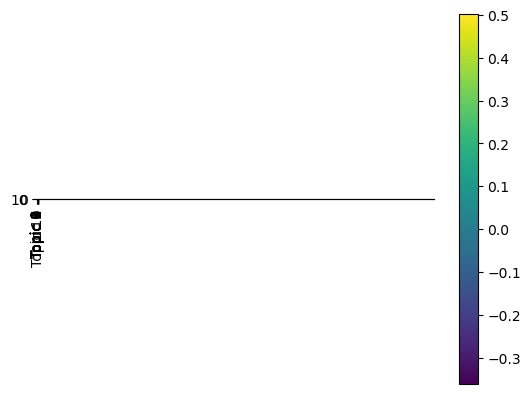

In [62]:
# визуализация модели LSA, к сожалению, через pyLDAvis невозможно вывести модель LSA
plt.imshow(lsa_model.components_, cmap='viridis', interpolation='none')
plt.colorbar()
plt.xticks(range(11), ['Topic ' + str(i) for i in range(11)], rotation=90)
plt.show()

In [63]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 0, 'keyword'])

1     файл, уязвимость, процесс, весь, код, использо...
2     плата, процессор, сервер, слот, контроллер, си...
12    ошибка, команда, мочь, проблема, файл, проверя...
21    лидар, мочь, объект, автомобиль, система, бесп...
25    класс, объект, десериализация, поле, значение,...
28    качество, звук, пакет, звонок, сигнал, мочь, и...
31    приложение, клиент, версия, писать, весь, стар...
32    приложение, станция, язык, поиск, программа, в...
48    устройство, преобразователь, кабель, производс...
51    метрика, приложение, мониторинг, сбор, собират...
52    мониторинг, метрика, система, мочь, запрос, по...
54    система, операционный, устройство, компьютер, ...
56    коммутатор, выделять, инсталляция, клиент, сер...
59    данные, база, инстанс, мочь, ресурс, использов...
60    частота, устройство, точка, доступ, работать, ...
63    код, проект, файл, работать, весь, просто, скр...
71    диск, система, данные, файловый, профиль, испо...
72    ряд, временный, средний, данные, мочь, мет

### 2.4 Разведочный анализ

### Вывод

In [64]:
topics = []

for i, topic in enumerate(lda_model.components_):
    top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
    topic_string = f"Topic {i}: {', '.join(top_words)}"
    topics.append(topic_string)

In [65]:
dfCosinTest = pd.DataFrame({'texts': topics})

In [66]:
dfj = {'texts': [], 'cos_similarities' : [], 'cluster': []}

In [67]:
for i in range(0, 11):
    find_nearest_to = str(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == i, 'keyword'])
    # формирование весов tf-idf
    tfidf = TfidfVectorizer()
    mx_tf = tfidf.fit_transform(topics)
    new_entry = tfidf.transform([find_nearest_to])
    sdf = pd.DataFrame.sparse.from_spmatrix(mx_tf)
    new_entry = tfidf.transform([find_nearest_to])
    pd.DataFrame.sparse.from_spmatrix(new_entry)
    cosine_similarities = cosine_similarity(new_entry, mx_tf).flatten()
    dfCosinTest['cos_similarities'] = cosine_similarities
    dfCosinTest = dfCosinTest.sort_values(by=['cos_similarities'], ascending=[0])
    dfCosinTest = dfCosinTest.reset_index(drop=True)
    dfj['texts'].append(dfCosinTest['texts'][0])
    dfj['cos_similarities'].append(dfCosinTest['cos_similarities'][0])
    dfj['cluster'].append(i)

In [68]:
dfClusters = pd.DataFrame(data = dfj)

In [69]:
dfClusters.head(15)

,texts,cos_similarities,cluster
0,"Topic 6: система, мочь, устройство, работа, пл...",0.467358,0
1,"Topic 0: данные, мочь, весь, использовать, фай...",0.398931,1
2,"Topic 5: весь, код, статья, сумма, лидар, мочь...",0.606839,2
3,"Topic 5: весь, код, статья, сумма, лидар, мочь...",0.419112,3
4,"Topic 3: работа, мочь, данные, анимация, испол...",0.673266,4
5,"Topic 6: система, мочь, устройство, работа, пл...",0.793603,5
6,"Topic 7: система, устройство, операционный, оп...",0.762344,6
7,"Topic 7: система, устройство, операционный, оп...",0.222575,7
8,"Topic 8: мочь, приложение, имя, система, польз...",0.651142,8
9,"Topic 5: весь, код, статья, сумма, лидар, мочь...",0.423164,9


Кластеры - Темы
 0        -  6
 1        -  0
 2        -  5
 3        -  5
 4        -  3
 5        -  6
 6        -  7
 7        -  7
 8        -  8
 9        -  5
10        -  2
темы не использованы 1, 4, 9, 10
темы повторены 7, 5, 6

In [70]:
dfCosinTest['texts'][1]

'Topic 5: весь, код, статья, сумма, лидар, мочь, балл, проект, приложение, станция'

In [71]:
dfCosinTest['cos_similarities'][1]

0.0

In [72]:
dfCosinTest.head(1)

,texts,cos_similarities
0,"Topic 2: класс, объект, десериализация, поле, ...",0.623691


In [73]:
dfCosinTest.head(1)

,texts,cos_similarities
0,"Topic 2: класс, объект, десериализация, поле, ...",0.623691


In [74]:
find_nearest_to = str(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 0, 'keyword'])

In [75]:
# формирование весов tf-idf
tfidf = TfidfVectorizer()
mx_tf = tfidf.fit_transform(topics)
new_entry = tfidf.transform([find_nearest_to])

In [76]:
type(mx_tf)

scipy.sparse._csr.csr_matrix

In [77]:
sdf = pd.DataFrame.sparse.from_spmatrix(mx_tf)
sdf

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,0.000000,0.138089,0.000000,0.000000,0.000000,0.177814,0.000000,0.000000,0.000000,0.289795,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.38551,0.329520,0.000000,0.000000,0.000000
1,0.000000,0.100503,0.000000,0.000000,0.000000,0.129416,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.561162,0.000000
2,0.000000,0.114079,0.000000,0.000000,0.318482,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.144696,0.403956,0.000000,0.000000,0.186322,0.345287,0.303661,0.000000,0.303661,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.122120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.256283,...,0.340931,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.340931
5,0.000000,0.128983,0.000000,0.360088,0.000000,0.166088,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.360088,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.142780,0.000000,0.000000,0.000000,0.183856,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.340716,0.00000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.103984,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.248136,0.00000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.137035,0.000000,0.000000,0.000000,0.176458,0.000000,0.287584,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.135405,0.000000,0.000000,0.000000,0.174358,0.323116,0.284162,0.378018,0.000000,...,0.000000,0.000000,0.000000,0.378018,0.000000,0.00000,0.000000,0.378018,0.000000,0.000000


In [78]:
cosine_similarity(mx_tf)

array([[1.        , 0.05629081, 0.10545741, 0.23932219, 0.11470609,
        0.07224171, 0.26159235, 0.01435898, 0.07675203, 0.07583879,
        0.2296883 ],
       [0.05629081, 1.        , 0.01146536, 0.05898418, 0.02943043,
        0.05257875, 0.05820329, 0.04720987, 0.10430463, 0.10306355,
        0.12285286],
       [0.10545741, 0.01146536, 1.        , 0.01650682, 0.01393141,
        0.01471425, 0.01628829, 0.0118624 , 0.01563291, 0.0154469 ,
        0.01430175],
       [0.23932219, 0.05898418, 0.01650682, 1.        , 0.2208163 ,
        0.07569829, 0.24745313, 0.08131132, 0.16775239, 0.27732408,
        0.13738164],
       [0.11470609, 0.02943043, 0.01393141, 0.2208163 , 1.        ,
        0.03777001, 0.0418104 , 0.01269853, 0.04012813, 0.03965066,
        0.03671117],
       [0.07224171, 0.05257875, 0.01471425, 0.07569829, 0.03777001,
        1.        , 0.07469612, 0.01341209, 0.17234018, 0.17028958,
        0.15766519],
       [0.26159235, 0.05820329, 0.01628829, 0.24745313, 0.

In [79]:
new_entry = tfidf.transform([find_nearest_to])
pd.DataFrame.sparse.from_spmatrix(new_entry)

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,0.0,0.0,0.0,0.0,0.0,0.148523,0.0,0.0,0.0,0.242057,...,0.0,0.0,0.0,0.0,0.275239,0.322006,0.0,0.0,0.0,0.0


In [80]:
cosine_similarities = cosine_similarity(new_entry, mx_tf).flatten()
cosine_similarities

array([0.39729796, 0.11734167, 0.19589771, 0.17951505, 0.16474525,
       0.34123143, 0.4673583 , 0.40583466, 0.40708225, 0.11751599,
       0.18431081])

In [81]:
# запишем все попарные результаты сравнений
dfCosinTest['cos_similarities'] = cosine_similarities
# и отсортируем по убыванию (т.к. cos(0)=1)
dfCosinTest = dfCosinTest.sort_values(by=['cos_similarities'], ascending=[0])
dfCosinTest

,texts,cos_similarities
6,"Topic 10: пакет, функция, мочь, код, схема, ко...",0.467358
8,"Topic 4: реактивный, мочь, данные, стрим, опер...",0.407082
7,"Topic 3: работа, мочь, данные, анимация, испол...",0.405835
0,"Topic 2: класс, объект, десериализация, поле, ...",0.397298
5,"Topic 8: мочь, приложение, имя, система, польз...",0.341231
2,"Topic 6: система, мочь, устройство, работа, пл...",0.195898
10,"Topic 9: год, мочь, весь, тест, человек, серве...",0.184311
3,"Topic 1: мочь, дыра, игра, ошибка, команда, се...",0.179515
4,"Topic 0: данные, мочь, весь, использовать, фай...",0.164745
9,"Topic 7: система, устройство, операционный, оп...",0.117516


0 = 14

1 = 15

2 = 6

3 = 2

4 = 3

5 = 5

6 = 4

7 = 8

8 = 1

9 = 13

10 = 7

11 = 9

12 = 10

13 = 11

14 = 12

In [82]:
X = dfHabr1['keyword']
y = dfHabr1['clustersAgglomerative']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [84]:
my_tags = dfHabr1['clustersKmeans'].unique()
my_tags

array([ 4,  2,  7,  9, 10,  6,  8,  3,  0,  1,  5], dtype=int64)

In [85]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

In [86]:
%%time
nb.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 3 ms


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [87]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

CPU times: total: 0 ns
Wall time: 1 ms


In [88]:
y_pred[0]

1

In [89]:
print(X_test[0], y_test[0], y_pred[0])

код, модель, плагин, поиск, данные, разработка, новый, любой, ответ, задача 1 1


In [90]:
my_tags

array([ 4,  2,  7,  9, 10,  6,  8,  3,  0,  1,  5], dtype=int64)

In [91]:
from sklearn.metrics import accuracy_score

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7407407407407407
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.77      0.95      0.85        21
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1

    accuracy                           0.74        27
   macro avg       0.13      0.16      0.14        27
weighted avg       0.60      0.74      0.66        27



C:\Users\essww\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\essww\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\essww\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

In [93]:
%%time
sgd.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 5.51 ms


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [94]:
%%time
y_pred = sgd.predict(X_test)

CPU times: total: 0 ns
Wall time: 1.34 ms


In [95]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.5925925925925926
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.73      0.76      0.74        21
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1

    accuracy                           0.59        27
   macro avg       0.10      0.11      0.11        27
weighted avg       0.57      0.59      0.58        27



C:\Users\essww\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\essww\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\essww\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\essww\anaconda3\lib\site-packages\sklearn\metrics\_cla

In [96]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])

In [97]:
%%time
logreg.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 13.2 ms


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=100000.0, n_jobs=1))])

In [98]:
%%time
y_pred = logreg.predict(X_test)

CPU times: total: 0 ns
Wall time: 1 ms


In [99]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.6666666666666666
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.75      0.86      0.80        21
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1

    accuracy                           0.67        27
   macro avg       0.12      0.14      0.13        27
weighted avg       0.58      0.67      0.62        27



C:\Users\essww\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\essww\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\essww\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [100]:
econ_text = 'время неумолимо бежать вперед выходить новый гаджет постепенно заменять старый превращать тыква хороший случай тапочек звонок смартфон становиться практически одинаковый дисплей весь площадь передний панель полный отсутствие аппаратный кнопка беспроводной зарядка это здорово хотеться взять рука старый необычный наш время qwerty смартфон попытаться использовать основной цена мочь приятно удивлять бу девайс купить несколько сотня рубль проблема клиент приложение версия android безбожно устаревать давно работать желание воскрешать старый девайс превыше потребительский качество приходить мысль почему написать ноль свой клиент популярный приложение вк музыка youtube трекинг посылка садиться писать необходимый повседневный жизнь приложение ноль голый api android либо фреймворков appcompat получаться это узнавать статья мотивация самый дело копаться старый девайса пытаться находить применение это очень интересный затягивать дело зачастую попытка оживлять девайс заключаться прочтение большой количество мануал документация копание терминал компиляция загрузчик ядро подобный занятие интересный весь уровень хардварный системный прикладной пользовательский предыдущий статья моддиль девайса весь уровень ремонтировать железный болячка написать несколько статья системный моддинг компиляция загрузчик неизвестный китайский устройство узнавать пользовательский опыт установка готовый кастомный прошивка летний устройство сегодняшний день обходить прикладной уровень моддинг устройство т е написание самый обычный повседневный программа который сложно представлять жизнь современный человек время выход первый galaxy s год многие сутки красноглазить java версия аська сидеть вконтакте большинство заглядывать смартфон каждый пара минута проверка нотификация год смартфонный жизнь становиться похожий который привыкать соц сеть мессенджер пушить потоковый видео многие успевать привязываться жизнь конкретно самый девайса год давно миновать тенденция разработка приложение кардинальный поменяться учитывать многий читатель любить выбрасывать девайса мусорка правильно делать наверняка регулярно заглядывать полочка свой пыльный бывший гаджет рассматривать теплота сожаление понимать время проходить проходить посмотреть навык огромный мотивация программер мочь многое число запиливать весь самый необходимый приложение давно лелеять идея подумывать реализовать весь свой жизнь писать c практически щупать api android ui фрейморк день очень сильно зачесываться рука написать эдакий причем сразу весьма серьезный весь устройство год самый молодой являться реплика lumia который успевать замоддить рождаться идея написать клиент youtube вк трекинг придача б выделять неделя время должный успевать заканчивать пусть сыроватый вполне юзабельный клиент любить сервис начинать думать планирование написание приложение старый мобильный ос любой платформа требовать планирование работать учет ограничение целевой платформа сразу несколько ограничение раззадоривать пыл большинство свой старый версия android работать одноядерный чипсет значит лимитировать многопоточность никакой работа ui поток кроме обновление интерфейс поскольку первый версия система интерфейс менее отзывчивый свежий нужно сохранять баланс функционал симпатичность скорость работа приложение должный оптимально работать следующий условие мб озу который свободно средний мб сбер привет вылет гб озу ядро мгц видео ядро уровень mali malii негусто сходить второй ограничение становиться тотальный устаревание корневой сертификат многие знать просто мобильный система обновлять поэтому приходиться идти хаки делать сервер реле который преобразовывать трафик https http просто отключать проверка верификация ssl это кейс api vk решать отдельный сервер реле который отправлять запрос сервер вк обратно возвращать обычный результат json третий ограничение становиться android targetsdk android cupcake никакой appcompat кушать драгоценный свободный место никакой сервис google год чистый api система условие год назад писаться первый приложение android раздобывать лепешка расшибаться портировать свой приложение гордость сказать приложение работать android устройство полный энтузиазм садиться писать код основной часть статья решать поделить каждый приложение отдельно конкретный объяснение делать хотеться заранее сказать особо давно писать android зато писать winforms поэтому решение мочь показываться странный некоторый решение обусловливать версия android например нотификация первый версия android notification builder notification похожий структура приложение писать java вконтакте первый дело начинать писать клиент вк сразу определяться свой хотелок который весьма скромный возможность листать диалог читать сообщение отправлять полный поддержка qwerty клавиатура т е отправка enter плюс возможность слушать музыка ограничение вк бочка кой случай гнать просто публичный api ограничение хотя здорово снова хотеться почувствовать эмоция который ощущать прослушивание музыка школяр свой первый android смартфон год прилетать школа слушать плейлист практически девайса идентичный железо версия android помнить пользоваться прелесть многозадачность android g интернет g чипсет просто поддерживать песня слушать поставлять второй качаться пока песня доигрывать второй скачаться итак хотелка выбирать пора начинать писать приложение дебаг устройство galaxy s android jb китайский galaxy s mini i android фото высоко samsung galaxy s i android эмулятор kitkat android studio уметь проблема собирать приложение вплоть версия android последний build tools target sdk главное выкидывать appcompat androidx юнит тест build gradle либо проблема цеплять устройство adb отладчик проблема работать первый дело начинать писать активитя полноэкранный форма терминология android экран приложение диалог должный секунда подгружать данные строить морда весь суть весь код клиент получение ответ api вк разбор json датасет визуализация датасет экран это вводить объект vk который делать асинхронный запрос сервер оборачивать работа сервер реле парсить json vkobjectprocessor это скоро отрефакториться vkdataset поздно архитектура приложение получаться довольно простой примитивный старт активитя авторизация проверять данный приложение persiststorage наличие api токен отсутствие запрашивать авторизация это становиться классический среди различный самопальный клиент клиент прикидываться официальный приложение вк это использоваться связка app id app secret приложение вконтакте android авторизация приложение перенаправлять страница диалог поскольку пуша лонгполлинг метод обновление оставаться заданный интервал это handler который сечь брать список диалог сервер проверять обновляться данные обновлять датасет отправлять сигнал обновление интерфейс который построить listview кроме кеш аватарка точно распаралелленый несколько поток загружать данный момент превьюшка храниться хэшмап это сообщение реализовать схожий образ данный момент возможность горячий подгрузка сообщение сверху поэтому обновляться последний сообщение скоп сразу шустро весь это работать вполне неплохо основной процессорный время уходить разбор тяжелый json отчасти вино вк мало кастрировать функционал gethistory последний версия api возможность возвращать поле который нужный поступать аудиозапись музыка api настоящий заноза разработчик клиент который приходиться подолбаться правда недолго основной запрос сервер реле почему сделать музыка суть обход простой сгенерировать специальный api токен свободно обращаться метод связывать музыка необходимость притворяться официальный клиент подписывать запрос md ключ примитивный php скрипт предоставлять возможность позволять получать доступ база музыка вк однако ограничение типичный пользователь должный открытый аудиозапись php audiorelay for minivk c monobogdan token censored function vkrequest request global token curl curl init https api vk com method request access token token v curl setopt curl curlopt returntransfer true return curl exec curl function audioget uid get uid return vkrequest audio get owner id uid count function audiosearch query get query return vkrequest audio search q query count function audiogetdetails id get id return vkrequest audio getbyid audios id function audiostream url get url curl curl init urldecode url curl setopt curl curlopt returntransfer true return curl exec curl actions array actions get audioget actions search audiosearch actions getdetails audiogetdetails actions stream audiostream if isset get act act get act if isset actions act exit actions act exit internal error итог получаться рабочий плеер поиск музыка добавлять трек производительность оставаться отличный ссориться ребята вк хотеть поэтому добавлять возможность качать трек пока становиться стоить дружелюбный разработчик кастомный клиент получать итог довольно простенький клиент вк который практически потреблять озу шустро работать хватать куча различный фич минимум прсомотр лента стена успеться проект интересный продолжать наращивать фишечка потихоньку близко релиз слегка причесывать клиент добавлять вкшный дизайн приделывать анимированный боковой меню animation помнить youtube разработка клиент youtube свой особенность первый отличие клиент вк видео реле просто загружать слишком трафик второй youtube отдавать видео формат который поддерживать старый устройство основной это h p сожаление потоковый видео софтовый декодирование укладывать лопатка большинство одноядерник год ситуация осложняться videoview стандартный плеер весь смартфон который отлаживать приложение уметь игнорировать ошибка ssl просто валиться ошибка приходиться придумывать видосик хотеться смотреть крутой amoled дисплей galaxy s посидеть подумать придумывать поиск база youtube получение информация прямой ссылка видео решать использовать альтернативный фронтэнд youtube который называться invidous api крутой штука свой api который распределять пул токен ютуб отдавать ответ вид json формат запрос очень простой url инстанс invidous api v метод например search q test region ru hl ru выдавать результат поиск test российский регион очень удобно invidous отдельный сервис целый сеть т н инстанс хотеть юзай поскольку большинство инстанс прятаться свежий сертификат приходиться идти довольно известный костыль отключение верификация хостнейм httpurlconnection public static void disablesslcertificatechecking trustmanager trustallcerts new trustmanager new x trustmanager public x certificate getacceptedissuers return null override public void checkclienttrusted x certificate arg string arg throws certificateexception not implemented override public void checkservertrusted x certificate arg string arg throws certificateexception not implemented try sslcontext sc sslcontext getinstance tls sc init null trustallcerts new java security securerandom httpsurlconnection setdefaultsslsocketfactory sc getsocketfactory httpsurlconnection setdefaulthostnameverifier new hostnameverifier override public boolean verify string hostname sslsession session return true catch keymanagementexception e e printstacktrace catch nosuchalgorithmexception e e printstacktrace поскольку возможность воспроизводить потоковый видео онлайн решать просто предварительно загружать собственный менеджер закачка возможность последующий очистка кеш поскольку устройство p качество нужный выбирать p p mp avc кодек среднее ролик минута весить около мегабайт hsdpa загрузка подобный видео занимать около минута подождать закинуть тестовый версия беседа любитель ретро мобилка человек восторг поскольку invidous отчасти строиться анонимность авторизация однако свой задача посмотреть видосик выполнять нормально поэтому весь ui приложение поделить вкладка тренд популярный история поиск подписка история реализовывать сторона клиент некоторые подход показываться плюс однако минимальный задел клиент мочь смотреть видео скачать приложение бэкэнд полностью открытый исходный код доступный лицензия gplv следить статус проект github последний версия скачать релиз проект текущий хотеться портировать android несмотря приложение целое иметь targetsdk оно работать отказываться android слегка поменяться бинарный формат xml разметка приложение старый система вылетать исключение это решать eclipse adt зуб импортировать проект вперед кроме экспериментировать попытка сильно уменьшать нагрузка сеть процессор путем облегчение датасет json вк весить среднее кб который ядерный чипсет частота мгц мочь долго жевать негативно сказываться ui примитивный keyvalue формат который содержать нужный поле умещаться кб текстовый вид благодаря свой примитивность весь парсинг substring indexof поиск ключ хешмап налегать процессор благодаря наработка запиливать примитивный клиент вкшечка j me целое сделать единый формат датасет мессенджер бэкэнд реализовывать угодно telegram вк личный сообщение хабер платформа делать морда заводить современный мессенджер sailfish j me symbian winmobile практически пот кровь полный адаптация кнопочный управление клиент проблема писать сообщение любой клавиатура число qwerty однако основной интерфейс полностью адаптировать кнопка требовать выполнение некоторый действие палец заключение получаться вполне неплохо приложение кой сыроватый явно дотягивать функционал большой версия кое таки выигрывать легкий быстрый самый главное мочь продлять жизнь любимый девайса считать это классно средний потребление озу оба клиент мб вес apk кб момент выход статья значить писать голый api модный фреймворков остальной функционал кой android продолжать неплохо работать наш время например dlna стриминг дом e mail клиент банкинг смска уверенный это покрывать потребность большинство пользователь это называть старый смартфон бесполезный писать статья цель показывать старый девайса отнюдь тыква щепотка энтузиазм глаз любовь гаджет заодно поделиться свой приложение часто комментарий писать хотеть пользоваться свой смартфон далеко устаревать версия android считать ждать ваш мнение комментарий зарегистрировать пользователь мочь участвовать опрос входить пожалуйста старенький девайс появляться второй жизнь определенно запланировать устаревание продолжать жить неюзабельный вокруг прыгать проголосовать пользователь воздерживаться пользователь зарегистрировать пользователь мочь участвовать опрос входить пожалуйста полезно развивать приложение старый система развивать это нужный пустой трата время делать модный приложенька флаттер проголосовать пользователь воздерживаться пользователь  \n'

In [101]:
ect_pred = nb.predict([econ_text])
ect_pred

array([1], dtype=int64)